In [1]:
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
import matplotlib.pyplot as plt

c:\Users\Joan\anaconda3\envs\DeepLearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


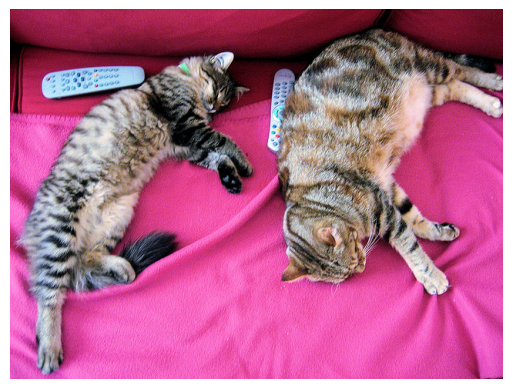

In [3]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.axis("off")
plt.show()

In [4]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]c:\Users\Joan\anaconda3\envs\DeepLearning\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.06s/it]


In [5]:
text_previous2images = ["There were 2 cats running around the house.", "The house was very big and had a lot of space for the cats to play around."]
text_previous2images_str = " ".join(text_previous2images)
prompt = f"Question: Exaplain the image as it is a story, Previous context: {text_previous2images_str} Answer:"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)
inputs["max_new_tokens"] = 256
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

The cats were sleeping on the couch.


In [6]:
text_previous2images = text_previous2images[1:] + [generated_text]
print(text_previous2images)

['The house was very big and had a lot of space for the cats to play around.', 'The cats were sleeping on the couch.']


In [26]:
def gen_text(model, processor, image, previous_text, tokens_max_lenght=256):
    text_previous_images_str = " ".join(previous_text)
    prompt = f"Question: Exaplain the image as it is a story for a kid, Previous context: {text_previous_images_str} Answer:"
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)
    inputs["max_new_tokens"] = tokens_max_lenght
    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    previous_text.append(generated_text)
    if len(previous_text) > 2:
        previous_text = previous_text[1:]
    return generated_text, previous_text

In [35]:
from PIL import ImageDraw, ImageFont
def plot_text_on_image(image, text):
    # Create a copy of the image to avoid modifying the original image
    image_with_text = image.copy()

    # Create a drawing object
    draw = ImageDraw.Draw(image_with_text)

    # Define the font size and font type
    font_size = 100
    font_type = "arial.ttf"  # Replace with the path to your desired font file

    # Load the font
    font = ImageFont.truetype(font_type, font_size)

    # Draw the text on the image
    draw.text((0, 0), text, font=font, fill=(255, 255, 255))  # You can customize the text color here

    # Show the image
    plt.imshow(image_with_text)
    plt.axis("off")
    plt.show()

### Test on a different image

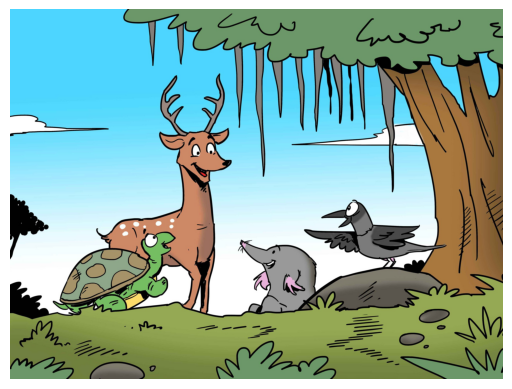

In [49]:
url = "https://kathakids.com/static/story-images/2020/10/Four_Friends_01-scaled.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.axis("off")
plt.show()

In [50]:
previoustext_list = []
text, previoustext_list = gen_text(model, processor, image, previoustext_list)
print(text)

The animals are in the jungle


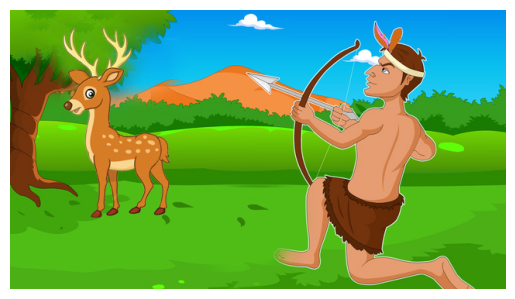

In [51]:
url = "https://1.bp.blogspot.com/-IEdk1FumpIE/XV2DW6HYBwI/AAAAAAAAASI/gl12B8pNptE2heWzVufafVr-nst552esQCLcBGAs/s1600/dear_hunter.jpg"
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.axis("off")
plt.show()

In [52]:
previoustext_list.append("They saw a person in the forest")

In [53]:
print(previoustext_list)

['The animals are in the jungle', 'They saw a person in the forest']


In [54]:
text, previoustext_list = gen_text(model, processor, image, previoustext_list)
print(text)
print(previoustext_list)

The person is a hunter and he is hunting the deer
['They saw a person in the forest', 'The person is a hunter and he is hunting the deer']


In [3]:
import paramiko
from paramiko import SSHClient
from scp import SCPClient
from pathlib import Path
from argparse import ArgumentParser
import time

def receive_image(remote_image_path, local_path, hostname, port, username, password):
    # Initialize SSH client
    ssh = SSHClient()
    ssh.load_system_host_keys()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

    # Connect to the server with the specified port
    ssh.connect(hostname, port=port, username=username, password=password)

    # SCPClient takes a paramiko transport as an argument
    scp = SCPClient(ssh.get_transport())

    # Transfer the file
    scp.get(remote_image_path, local_path)

    # Close SCP Client
    scp.close()

    # Close the SSH connection
    ssh.close()

def send_image(local_image_path, remote_path, hostname, port, username, password):
    # Initialize SSH client
    ssh = SSHClient()
    ssh.load_system_host_keys()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())

    # Connect to the server with the specified port
    ssh.connect(hostname, port=port, username=username, password=password)

    # SCPClient takes a paramiko transport as an argument
    scp = SCPClient(ssh.get_transport())

    # Transfer the file
    scp.put(local_image_path, remote_path)

    # Close SCP Client
    scp.close()

    # Close the SSH connection
    ssh.close()


def execute_ssh_command(host, port, username, password, command):
    # Initialize the SSH client
    client = paramiko.SSHClient()
    
    # Add the host key (this is not the safest approach, consider a better host key policy)
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    try:
        # Connect to the server
        client.connect(hostname=host, port=port, username=username, password=password)
        
        # Execute the command
        stdin, stdout, stderr = client.exec_command(command)
        
        # Read the standard output and print it
        print(stdout.read().decode())
        
        # Read the standard error and print it if not empty
        if stderr:
            print(stderr.read().decode())
    
    finally:
        # Close the connection
        client.close()


# Folder from which we are going to send the images of the wacom output to the cluster
FOLDER_SENDING_FROM_LOCAL = Path('Outputs/Wacom/Png_final_results')

# Folder in which we are going to save the image of the text2Sketch model in the cluster
FOLDER_SAVING_TO_LOCAL = Path('Outputs/Sketch2image')

# Folder from which we are going to retrieve the images from the text2Sketch model
FOLDER_GETTING_FROM_CLUSTER = Path('/hhome/nlp2_g05/social_inovation/Generated_imgs')

HOSTNAME = '158.109.75.52'
PORT = '55022'
USERNAME = 'nlp2_g05'
PASWORD = 'nlp_05'

def args():
    parser = ArgumentParser()
    parser.add_argument("--source", type=Path, help="source image file")
    args = parser.parse_args()
    path = args.source
    filename = path.name.split(".")[0]
    print(path, filename)
    return path, filename




In [5]:
send_image(r'C:\Users\34644\Desktop\Second Semester\Social Inovation\Story-Generation\sketch.png', 
           '/hhome/nlp2_g05/social_inovation/Sketches', 
           HOSTNAME, 
           PORT,
           USERNAME, 
           PASWORD)